In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import tensorflow as tf
import nltk
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = nltk.stem.WordNetLemmatizer()

email_data = pd.read_csv("spam_filtering.csv")
email_data

[nltk_data] Downloading package stopwords to /Users/mehdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mehdi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mehdi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mehdi/nltk_data...


,CLASS,SMS
0,pass,"said kiss, kiss, i can't do the sound effects..."
1,pass,&lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2,spam,(Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3,spam,* FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4,spam,**FREE MESSAGE**Thanks for using the Auction S...
...,...,...
1495,pass,"Yup, no need. I'll jus wait 4 e rain 2 stop."
1496,pass,Yup... From what i remb... I think should be c...
1497,pass,Yup... How Ã¼ noe leh...
1498,pass,Yup... Ok i go home look at the timings then i...


In [2]:
messages = email_data["SMS"]
messages

0        said kiss, kiss, i can't do the sound effects...
1           &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2       (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3       * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4       **FREE MESSAGE**Thanks for using the Auction S...
                              ...                        
1495         Yup, no need. I'll jus wait 4 e rain 2 stop.
1496    Yup... From what i remb... I think should be c...
1497                             Yup... How Ã¼ noe leh...
1498    Yup... Ok i go home look at the timings then i...
1499    <Forwarded from 21870000>Hi - this is your Mai...
Name: SMS, Length: 1500, dtype: object

In [3]:
classifications = email_data["CLASS"]
classifications

0       pass
1       pass
2       spam
3       spam
4       spam
        ... 
1495    pass
1496    pass
1497    pass
1498    pass
1499    spam
Name: CLASS, Length: 1500, dtype: object

In [4]:
# Custom tokenizer to remove stopwords and use lemmatization
def custom_tokenize(str):
    # Split string as tokens
    tokens = nltk.word_tokenize(str)
    
    # Filter for stopwords
    nostop = list(filter(lambda token: token not in nltk.corpus.stopwords.words('english'), tokens))
    
    # Perform lemmatization
    lemmatized = [lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

# Build a TF-IDF Vectorizer model
vectorizer = sk.feature_extraction.text.TfidfVectorizer(tokenizer = custom_tokenize)

# Transform feature input to TF-IDF
tfidf = vectorizer.fit_transform(messages)

# Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

# Build a label encoder for target variable to convert strings to numeric values.
label_encoder = sk.preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(classifications)

# Convert target to one-hot encoding vector
spam_classes = tf.keras.utils.to_categorical(spam_classes, 2)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

/Users/mehdi/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF Matrix Shape :  (1500, 4566)
One-hot Encoding Shape :  (1500, 2)


In [5]:
X_train,X_test,Y_train,Y_test = sk.model_selection.train_test_split(tfidf_array, spam_classes, test_size = 0.10)

# Setup Hyper Parameters for building the model
NB_CLASSES = 2
N_HIDDEN = 32

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(N_HIDDEN,
                                input_shape = (X_train.shape[1], ),
                                name = 'Hidden-Layer-1',
                                activation = 'relu'))

model.add(tf.keras.layers.Dense(N_HIDDEN,
                                name = 'Hidden-Layer-2',
                                activation = 'relu'))

model.add(tf.keras.layers.Dense(NB_CLASSES,
                                name = 'Output-Layer',
                                activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                146144    
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147,266
Trainable params: 147,266
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Make it verbose so we can see the progress
VERBOSE = 1

# Setup Hyper Parameters for training
BATCH_SIZE = 256
EPOCHS = 10
VALIDATION_SPLIT = 0.2

history = model.fit(X_train,
                    Y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = VERBOSE,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/10


2023-09-04 19:04:21.553751: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 0s 23ms/step - loss: 0.6819 - accuracy: 0.6843 - val_loss: 0.6544 - val_accuracy: 0.9222
Epoch 2/10
5/5 [==============================] - 0s 6ms/step - loss: 0.6278 - accuracy: 0.9685 - val_loss: 0.6006 - val_accuracy: 0.9667
Epoch 3/10
5/5 [==============================] - 0s 7ms/step - loss: 0.5579 - accuracy: 0.9833 - val_loss: 0.5392 - val_accuracy: 0.9667
Epoch 4/10
5/5 [==============================] - 0s 7ms/step - loss: 0.4830 - accuracy: 0.9880 - val_loss: 0.4788 - val_accuracy: 0.9593
Epoch 5/10
5/5 [==============================] - 0s 7ms/step - loss: 0.4107 - accuracy: 0.9907 - val_loss: 0.4226 - val_accuracy: 0.9630
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.3450 - accuracy: 0.9907 - val_loss: 0.3714 - val_accuracy: 0.9630
Epoch 7/10
5/5 [==============================] - 0s 7ms/step - loss: 0.2860 - accuracy: 0.9917 - val_loss: 0.3262 - val_accuracy: 0.9630
Epoch 8/10
5/5 [============================

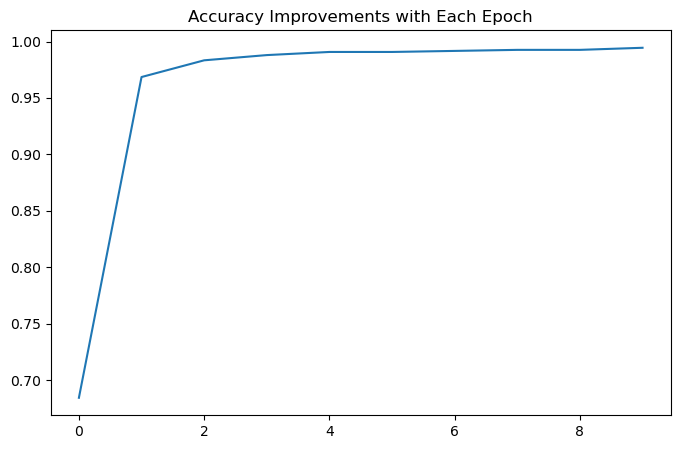

In [7]:
pd.DataFrame(history.history)["accuracy"].plot(figsize = (8, 5))
plt.title("Accuracy Improvements with Each Epoch")
plt.show()

In [8]:
model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 932us/step - loss: 0.2319 - accuracy: 0.9667


[0.23188886046409607, 0.9666666388511658]

In [9]:
# Predict for multiple samples using batch processing

# Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf = vectorizer.transform(["FREE entry to a fun contest", "Yup I will come over"]).toarray()

predict_tfidf.shape

(2, 4566)

In [10]:
# Predict using model
prediction = np.argmax( model.predict(predict_tfidf), axis = 1 )
prediction

1/1 [==============================] - 0s 36ms/step


array([1, 0])

In [11]:
# Print prediction classes
label_encoder.inverse_transform(prediction)

array(['spam', 'pass'], dtype=object)